## Introducción al análisis

El servicio de telefonía virtual **CallMeMaybe** está desarrollando una nueva función que permitirá a supervisores y supervisoras **identificar a los operadores menos eficaces**.  

Se considera que un operador es ineficaz si cumple con alguno de los siguientes criterios:  
- Presenta una **alta cantidad de llamadas entrantes perdidas** (tanto internas como externas).  
- Tiene un **tiempo de espera prolongado** para las llamadas entrantes.  
- En el caso de que deba realizar llamadas salientes, un **número reducido de estas** también se interpreta como un indicador de ineficiencia.  

Para evaluar el desempeño de los operadores, se tomarán en cuenta las siguientes métricas clave:  

1. **Tasa de llamadas perdidas (Abandonment Rate):**  
   - Porcentaje de llamadas no atendidas o abandonadas.  
   - Benchmark recomendado según la bibliografía (NAQC, 2005; Cleveland, 2019; ICMI, 2022): ≤ **5–8%**.  

2. **Tiempo promedio de espera (Average Speed of Answer, ASA; Service Level 80/20):**  
   - Tiempo promedio que un cliente espera en la cola antes de ser atendido.  
   - Benchmark recomendado (ICMI, 2022; Cleveland, 2019): **80% de las llamadas contestadas en ≤ 20 segundos**.  

3. **Baja cantidad de llamadas salientes:**
   - En este caso tomaremos los operadores que estén por debajo del primer quartil.

---

## Objetivos del análisis

1. **Realizar un análisis exploratorio de los datos** para identificar tendencias y patrones de desempeño de los operadores.  
2. **Identificar a los operadores ineficaces** usando métricas clave como la tasa de llamadas perdidas, tiempo promedio de espera y volumen de llamadas salientes.  
3. **Probar hipótesis estadísticas** que permitan validar la significancia de los hallazgos y establecer umbrales de desempeño.  

---

## Bibliografía consultada

1. **ICMI’s Guide to Call Center Metrics** (Brad Cleveland, 2022)  
   - Proporciona definiciones detalladas de métricas clave, incluyendo tasa de abandono, ASA y nivel de servicio.  
   - Explica la importancia de usar percentiles y comparaciones con benchmarks internos y externos para identificar operadores críticos.  
   - Recomendación de la industria: 80% de llamadas contestadas en ≤ 20 segundos como estándar de servicio.

2. **Contact Center Management on Fast Forward** (Brad Cleveland, 4ª edición, 2019)  
   - Guía práctica para la gestión de centros de contacto.  
   - Incluye estrategias para medir eficiencia y productividad de operadores.  
   - Presenta benchmarks históricos de tasa de abandono (≤5–8%), tiempos de espera y resolución en primera llamada (FCR).  
   - Explica cómo balancear eficiencia operativa y calidad de atención al cliente.

3. **SQM Group. Call Abandonment Rate: A Comprehensive Guide.** Recuperado de https://www.sqmgroup.com/resources/library/blog/call-abandonment-rate-comprehensive-guide
   - Indica la cantidad de tasa de abandono aceptable para las buenas prácticas en un call center,no mayor a 5-8%
4. **NAQC Issue Paper – Call Center Metrics: Best Practices in Performance Measurement and Management** (2005)  
   - Documento técnico orientado a la salud pública, pero aplicable a cualquier call center.  
   - Define métricas operativas como Abandonment Rate, ASA, AHT y nivel de servicio.  
   - Contiene buenas prácticas para establecer umbral de eficiencia y monitorear el desempeño de los operadores.  

5. **Performance improvement strategies to increase call center service level: a literature review** (Purba & Hidayati, 2020)  
   - Revisión académica de estrategias para mejorar el nivel de servicio en call centers.  
   - Analiza la relación entre tiempo de espera, tasa de abandono y productividad de operadores.  
   - Presenta recomendaciones sobre cómo priorizar la eficiencia sin afectar la experiencia del cliente.  



In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import chi2_contingency


## Carga de datos

In [56]:
df_clients = pd.read_csv("telecom_clients_us.csv")
df_dataset = pd.read_csv("telecom_dataset_us.csv")

## Preparacion de datos

In [57]:
df_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [58]:
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      732 non-null    int64 
 1   tariff_plan  732 non-null    object
 2   date_start   732 non-null    object
dtypes: int64(1), object(2)
memory usage: 17.3+ KB


In [59]:
#Cambiamos el tipo de dato de la columna "date_start"
df_clients['date_start'] = pd.to_datetime(df_clients['date_start'])

In [60]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              53902 non-null  int64  
 1   date                 53902 non-null  object 
 2   direction            53902 non-null  object 
 3   internal             53785 non-null  object 
 4   operator_id          45730 non-null  float64
 5   is_missed_call       53902 non-null  bool   
 6   calls_count          53902 non-null  int64  
 7   call_duration        53902 non-null  int64  
 8   total_call_duration  53902 non-null  int64  
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 3.3+ MB


In [61]:
df_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [62]:
#cambiamos el tipo de dato de la columna "date"
df_dataset['date'] = pd.to_datetime(df_dataset['date'])

In [63]:
#Vemos la cantidad de nulos
df_dataset.isnull().sum()

user_id                   0
date                      0
direction                 0
internal                117
operator_id            8172
is_missed_call            0
calls_count               0
call_duration             0
total_call_duration       0
dtype: int64

* Observamos que la cantidad de nulos en la columna "operador_id" es debido a que ningun operador contesto la llamada,por lo tanto matendremos esos datos ya que nos brinda informacion importante.
* La cantidad de nulos en la columna "internal" es menos 117,no sabemos el origen de estos nulos asi que por el momento los mantendremos tal cual.

In [64]:
#Vemos si existen duplicados
df_dataset.duplicated().sum()


4900

In [65]:
df_dataset[df_dataset.duplicated()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
44,166377,2019-08-14 00:00:00+03:00,out,False,880026.0,False,10,1567,1654
45,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
51,166377,2019-08-15 00:00:00+03:00,out,False,880026.0,False,11,1413,1473


In [66]:
# Filtrar todas las filas duplicadas
duplicados = df_dataset[df_dataset.duplicated(keep=False)]

duplicados


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
6,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
8,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,True,8,0,50
27,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
28,166377,2019-08-12 00:00:00+03:00,in,False,NaN,True,2,0,34
38,166377,2019-08-14 00:00:00+03:00,in,False,NaN,True,1,0,3
...,...,...,...,...,...,...,...,...,...
53875,168601,2019-11-26 00:00:00+03:00,in,False,NaN,True,3,0,35
53883,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89
53885,168603,2019-11-20 00:00:00+03:00,out,False,959118.0,True,3,0,89
53899,168606,2019-11-15 00:00:00+03:00,out,True,957922.0,False,4,3130,3190


In [67]:
#Eliminamos todos los duplicados
df_dataset = df_dataset.drop_duplicates()
df_dataset.duplicated().sum()

0

In [68]:
#Vemos de que fecha a que fecha comprenden nuestros datos
print(df_dataset['date'].min())
print(df_dataset['date'].max())

2019-08-02 00:00:00+03:00
2019-11-28 00:00:00+03:00


* Vemos que nuestros datos comprenden alrededor de 4 meses, desde el 2-agosto hasta el 28-nov.

## Análisis de los datos

In [69]:
df_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25


In [70]:
#Calculamos que cantidad de llamadas perdidas en general tenemos
df_dataset['is_missed_call'].value_counts()

is_missed_call
False    27549
True     21453
Name: count, dtype: int64

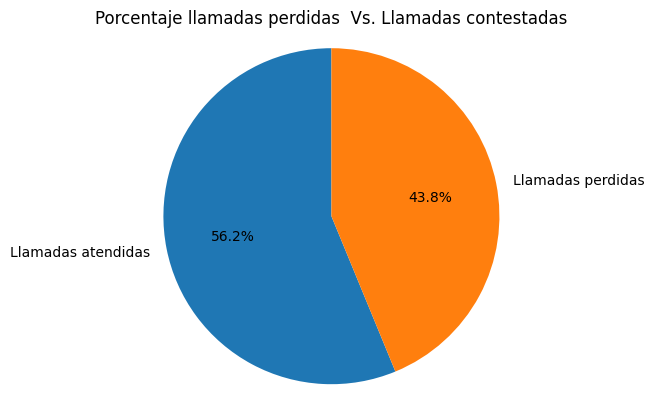

In [71]:
#Graficamos en forma de pie la cantidad de llamadas perdidas
sizes = [56.22,43.78 ]
labels = ['Llamadas atendidas', 'Llamadas perdidas']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje llamadas perdidas  Vs. Llamadas contestadas')
plt.axis('equal')
plt.show()

* Este valor es muy alto. En la práctica, un call center bien gestionado debería tener tasas de abandono menores al 5–10% (dependiendo de la industria).

In [72]:
#Calculamos las llamadas perdidas por operador
calls_per_operator = df_dataset.groupby('operator_id').agg(
    total_calls = ('is_missed_call','count'),
    missed_call = ('is_missed_call','sum')
).reset_index()
calls_per_operator['%_missed_call'] = ((calls_per_operator['missed_call']/calls_per_operator['total_calls'])*100).round(2)
calls_per_operator.head()

,operator_id,total_calls,missed_call,%_missed_call
0,879896.0,117,47,40.17
1,879898.0,227,89,39.21
2,880020.0,20,6,30.00
3,880022.0,70,29,41.43
4,880026.0,182,87,47.80


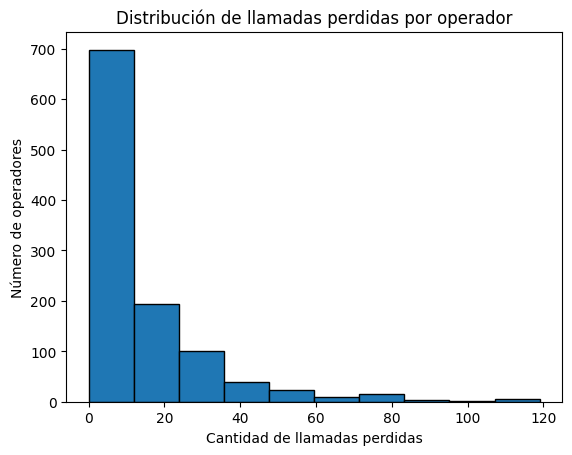

In [73]:
#Hacemos un histograma del numero de llamadas de los operadores
plt.hist(calls_per_operator['missed_call'], bins=10, edgecolor='black')
plt.title("Distribución de llamadas perdidas por operador")
plt.xlabel("Cantidad de llamadas perdidas")
plt.ylabel("Número de operadores")
plt.show()

   hour  is_missed_call
0     0           21453


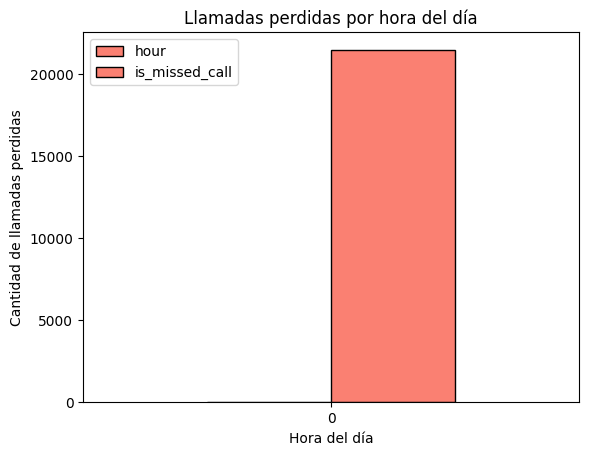

In [74]:
#Vemos si existen horas picos en las que hayan más llamadas perdidas

#creamos la columna hora
df_dataset['hour'] = df_dataset['date'].dt.hour
df_call_missed_per_hour = df_dataset.groupby('hour')['is_missed_call'].sum().reset_index()
print(df_call_missed_per_hour.head())
df_call_missed_per_hour.plot(kind='bar', color='salmon', edgecolor='black')
plt.title("Llamadas perdidas por hora del día")
plt.xlabel("Hora del día")
plt.ylabel("Cantidad de llamadas perdidas")
plt.xticks(rotation=0)
plt.show()



In [75]:
df_dataset['hour'].unique()

array([0], dtype=int32)

* Podemos observar que el dataset no contiene la hora de las llamadas,por lo que no podemos determinar si las llamadas perdidas podria deberse a horas pico de alta demanda.

In [76]:
#Calculamos el percentil 95 de la tasa de llamadas perdidas por operador para tener una idea 
print(np.percentile(calls_per_operator['%_missed_call'],95))

66.67


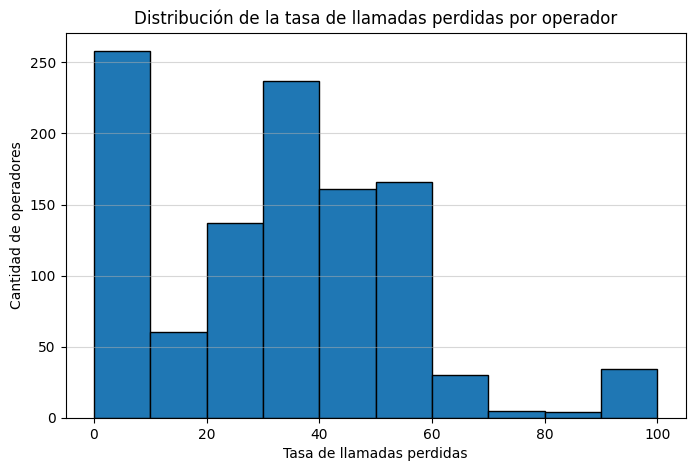

In [77]:
#Graficamos la tasa de distribucion de llamdas perdiddas por operador
plt.figure(figsize=(8,5))
plt.hist(calls_per_operator['%_missed_call'], bins=10, edgecolor='black')
plt.title("Distribución de la tasa de llamadas perdidas por operador")
plt.xlabel("Tasa de llamadas perdidas")
plt.ylabel("Cantidad de operadores")
plt.grid(axis='y', alpha=0.5)
plt.show()


In [78]:
#calculamos el tiempo de espera
df_dataset['waiting_time'] = df_dataset['total_call_duration'] - df_dataset['call_duration']
df_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,hour,waiting_time
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,0,25


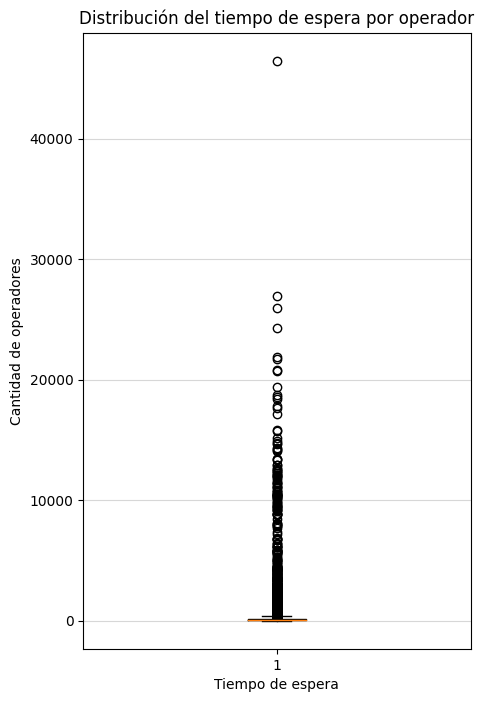

In [79]:
#Graficamos un histograma del tiempo de espera de las llamadas que fueron contestadas
df_dataset_1 = df_dataset[df_dataset['is_missed_call'] == False]
plt.figure(figsize=(5,8))
plt.boxplot(df_dataset_1['waiting_time'])
plt.title("Distribución del tiempo de espera por operador")
plt.xlabel("Tiempo de espera")
plt.ylabel("Cantidad de operadores")
plt.grid(axis='y', alpha=0.5)
plt.show()

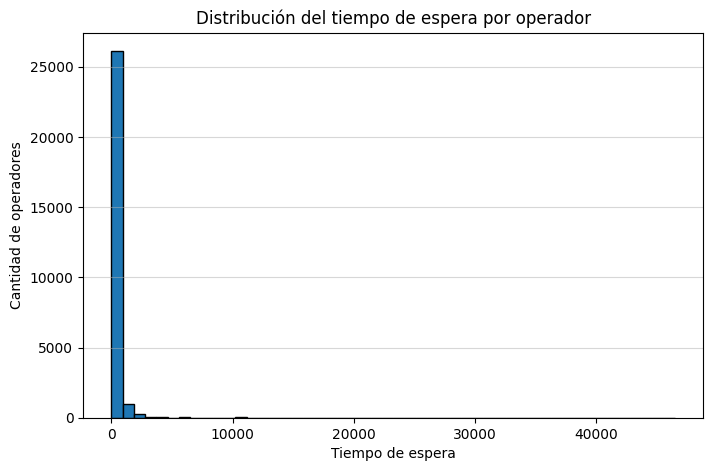

In [80]:
plt.figure(figsize=(8,5))
plt.hist(df_dataset_1['waiting_time'], bins=50, edgecolor='black')
plt.title("Distribución del tiempo de espera por operador")
plt.xlabel("Tiempo de espera")
plt.ylabel("Cantidad de operadores")
plt.grid(axis='y', alpha=0.5)
plt.show()

In [81]:
#Calculamos el percentil 95 para ver el 90% de los operadores cuanto tarda en contestar una llamada.
print(np.percentile(df_dataset_1['waiting_time'],90))

509.0


In [82]:
df_dataset['waiting_time'].min()

0

In [83]:
df_dataset['total_call_duration'].max()

166155

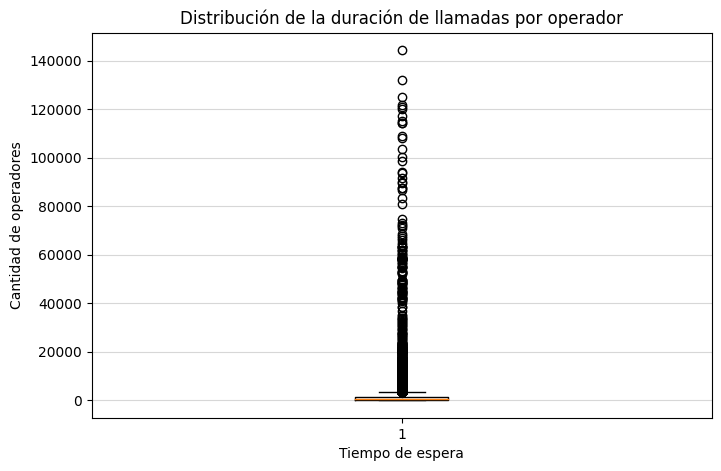

In [84]:
#Graficamos un histograma para ver la duracion de las llamadas por operador
plt.figure(figsize=(8,5))
plt.boxplot(df_dataset_1['call_duration'])
plt.title("Distribución de la duración de llamadas por operador")
plt.xlabel("Tiempo de espera")
plt.ylabel("Cantidad de operadores")
plt.grid(axis='y', alpha=0.5)
plt.show()

### Como mencionamos según la bibliografía que encontramos identificaremos aquellos operadores que tengan entre un  5–8% de llamadas perdidas y que al menos el 20% de sus llamadas contestadas tengan un tiempo de espera ≤ 20 segundos.

In [85]:
calls_per_operator.head()

,operator_id,total_calls,missed_call,%_missed_call
0,879896.0,117,47,40.17
1,879898.0,227,89,39.21
2,880020.0,20,6,30.00
3,880022.0,70,29,41.43
4,880026.0,182,87,47.80


In [86]:
#Clasificamos los operadores que tienen el 8% o mayor de llamadas perdidas y asi obtenemos nuestro primer df para despues filtrar los operadores ineficaces
calls_per_operator_filter_f= calls_per_operator[calls_per_operator['%_missed_call'] >= 8]
calls_per_operator_filter_f.head()

,operator_id,total_calls,missed_call,%_missed_call
0,879896.0,117,47,40.17
1,879898.0,227,89,39.21
2,880020.0,20,6,30.00
3,880022.0,70,29,41.43
4,880026.0,182,87,47.80


In [87]:
#Clasificamos los operadores que tienen el 20% de las llamdas contestadas en mas de 20 seg.
df_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,hour,waiting_time
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,0,25


In [88]:
#Filtramos las llamdas que fueron respondidas y creamos una columna boleana que nos indique si el tiempo de espera fue mayor a 20 seg.
df_dataset_filter = df_dataset[df_dataset['is_missed_call'] == False]
df_dataset_filter.loc[:, 'waiting_20'] = df_dataset_filter['waiting_time'] > 20
df_dataset_filter.head()

/tmp/ipykernel_45/547208580.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dataset_filter.loc[:, 'waiting_20'] = df_dataset_filter['waiting_time'] > 20


,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,hour,waiting_time,waiting_20
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0,8,False
5,166377,2019-08-05 00:00:00+03:00,out,False,880020.0,False,2,3,29,0,26,True
13,166377,2019-08-06 00:00:00+03:00,out,False,880020.0,False,5,800,819,0,19,False
15,166377,2019-08-07 00:00:00+03:00,out,False,880026.0,False,1,21,28,0,7,False
16,166377,2019-08-07 00:00:00+03:00,out,False,880020.0,False,2,232,240,0,8,False


In [89]:
#Calculamos el porentaje de llamadas respondidas que tuvieron un tiempo de espera mayor a 20 seg.
df_operador_waiting_time = df_dataset_filter.groupby('operator_id').agg(
    num_call_total = ('is_missed_call', 'count'),
    num_call_mayor_20 = ('waiting_20', 'sum')
                ).reset_index()
df_operador_waiting_time['%_call_mayor_20'] = (df_operador_waiting_time['num_call_mayor_20']/df_operador_waiting_time['num_call_total'])*100
df_operador_waiting_time.head()

,operator_id,num_call_total,num_call_mayor_20,%_call_mayor_20
0,879896.0,70,44,62.857143
1,879898.0,138,94,68.115942
2,880020.0,14,2,14.285714
3,880022.0,41,9,21.951220
4,880026.0,95,76,80.000000


In [90]:
#Calculamos que porcentaje de operadores tienen igual o más del 80% en tiempo de espera mayor o igual a 20 seg.
total = df_operador_waiting_time.shape[0]
print('Total de operadores:',total)
conteo = (df_operador_waiting_time['%_call_mayor_20'] >= 80).sum()
print('Operadores con tiempo de espera altos:',conteo)

Total de operadores: 1058
Operadores con tiempo de espera altos: 413


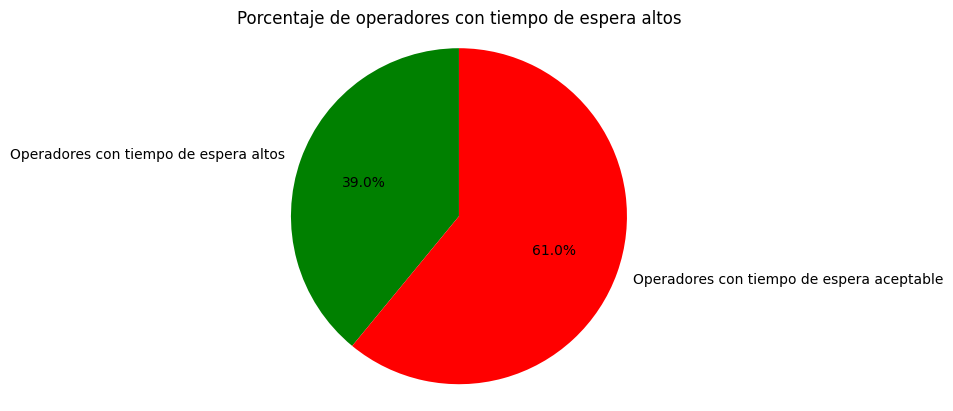

In [91]:
#Graficamos en un pie el anterior calculo en porcentaje
sizes = [39.04,60.96 ]
labels = ['Operadores con tiempo de espera altos', 'Operadores con tiempo de espera aceptable']
colors = ['green', 'red']
plt.pie(sizes, labels=labels, colors= colors,autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de operadores con tiempo de espera altos')
plt.axis('equal')
plt.show()

In [92]:
#Para nuestro segundo df final filtramos a los operadores que tienen el 80% o mas de llamadas con un tiempo de espera mayor a 20 seg.
df_operador_waiting_time_f = df_operador_waiting_time[df_operador_waiting_time['%_call_mayor_20'] >= 80]
df_operador_waiting_time_f.head()

,operator_id,num_call_total,num_call_mayor_20,%_call_mayor_20
4,880026.0,95,76,80.000000
11,882684.0,100,85,85.000000
12,882686.0,141,132,93.617021
13,882688.0,6,5,83.333333
14,882690.0,40,38,95.000000


In [93]:
#Ahora  para el siguiente df calculamos la cantidad de llamadas salientes por operador para despues filtrar los que tienen pocas llamadas salientes
df_dataset_out = df_dataset[df_dataset['direction'] == 'out']
df_operador_out = df_dataset_out.groupby('operator_id')['direction'].count().reset_index(name= 'num_call_out')
df_operador_out.head()

,operator_id,num_call_out
0,879896.0,96
1,879898.0,170
2,880020.0,13
3,880022.0,62
4,880026.0,164


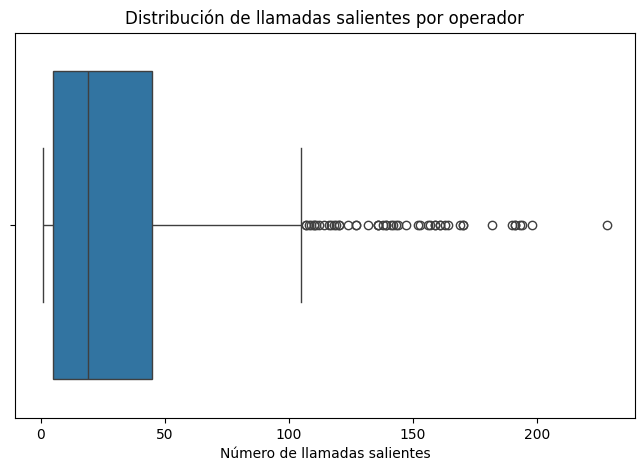

In [94]:
#Graficamos un boxplot para despues poder filtrar a los operadores que tienen por debajo del primer cuartil
plt.figure(figsize=(8,5))
sns.boxplot(x=df_operador_out['num_call_out'])
plt.title("Distribución de llamadas salientes por operador")
plt.xlabel("Número de llamadas salientes")
plt.show()

In [95]:
umbral = df_operador_out['num_call_out'].quantile(0.25)
print(umbral)

5.0


In [96]:
#Filtramos los operadores que tienen la cantidad de llamadas salientes por debajo del primera cuartil
df_operador_out_filter_f = df_operador_out[df_operador_out['num_call_out']<= 5]
print(df_operador_out_filter_f)

     operator_id  num_call_out
8       882478.0             1
13      883018.0             1
14      883898.0             1
17      884402.0             3
18      884406.0             2
..           ...           ...
876     970486.0             4
877     972408.0             2
878     972410.0             4
879     972412.0             4
881     973120.0             2

[238 rows x 2 columns]


Para calcular los operadores ineficientes,vemos que operadores se encuentran en los tres df que obtuvimos:

    - El primero con los operadores que tienen el 8% o más de llamadas perdidas.
    - El segundo con los operadores que tienen el 80% o más de sus llamadas contestadas con un tiempo de espera mayor o igual a 20 seg.
    - El tercero con los operadores que que tienen las llamadas salientes por debajo del primer cuartil tomando en cuenta la llamdas salientes de todos los operadores.

In [97]:
df_ineficientes_1 = calls_per_operator_filter_f.merge(
    df_operador_waiting_time_f, on='operator_id', how='inner'
).merge(
    df_operador_out_filter_f, on='operator_id', how='inner'
)

In [98]:
df_ineficientes_1.head()

,operator_id,total_calls,missed_call,%_missed_call,num_call_total,num_call_mayor_20,%_call_mayor_20,num_call_out
0,884406.0,2,1,50.00,1,1,100.0,2
1,891746.0,5,2,40.00,3,3,100.0,5
2,891918.0,6,1,16.67,5,5,100.0,1
3,891970.0,2,1,50.00,1,1,100.0,2
4,892798.0,4,2,50.00,2,2,100.0,3


In [99]:
df_ineficientes_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   operator_id        51 non-null     float64
 1   total_calls        51 non-null     int64  
 2   missed_call        51 non-null     int64  
 3   %_missed_call      51 non-null     float64
 4   num_call_total     51 non-null     int64  
 5   num_call_mayor_20  51 non-null     int64  
 6   %_call_mayor_20    51 non-null     float64
 7   num_call_out       51 non-null     int64  
dtypes: float64(3), int64(5)
memory usage: 3.3 KB


Numero de operadores total: 1092


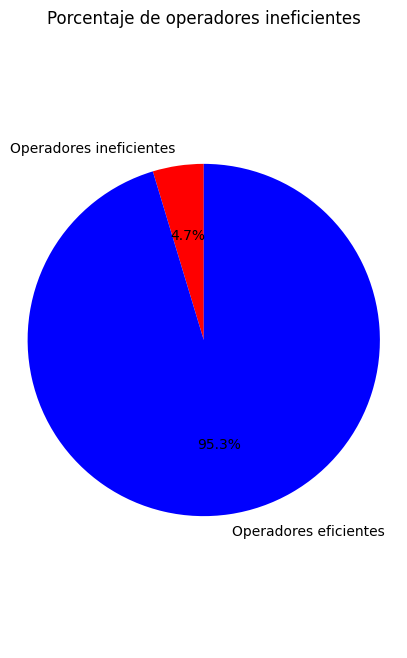

In [100]:
#Calculamos el porcentaje de operadores ineficientes en general
print('Numero de operadores total:',df_dataset['operator_id'].nunique())

plt.figure(figsize=(5,8))
sizes = [4.67,95.33 ]
labels = ['Operadores ineficientes', 'Operadores eficientes']
colors = ['red', 'blue']
plt.pie(sizes, labels=labels, colors= colors,autopct='%1.1f%%', startangle=90)
plt.title('Porcentaje de operadores ineficientes')
plt.axis('equal')
plt.show()

In [101]:
#Ahora vemos si existe alguna relacion de la ineficiencia de los operadores con el plan que adquiere el cliente
df_clients.head()

,user_id,tariff_plan,date_start
0,166713,A,2019-08-15
1,166901,A,2019-08-23
2,168527,A,2019-10-29
3,167097,A,2019-09-01
4,168193,A,2019-10-16


In [102]:
df_dataset.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,hour,waiting_time
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,0,4
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,0,5
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,0,1
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0,8
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,0,25


In [103]:
df_complet = df_dataset.merge(df_clients, on = 'user_id',how= 'left')
df_complet.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,hour,waiting_time,tariff_plan,date_start
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,0,4,B,2019-08-01
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,0,5,B,2019-08-01
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,0,1,B,2019-08-01
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0,8,B,2019-08-01
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,0,25,B,2019-08-01


In [104]:
#Creo una columna boleana en el dataset completo que indique si el operador es ineficiente o no
ineficientes_id = df_ineficientes_1['operator_id'].unique()
df_complet['ineficient'] = df_complet['operator_id'].isin(ineficientes_id)
df_complet.head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,hour,waiting_time,tariff_plan,date_start,ineficient
0,166377,2019-08-04 00:00:00+03:00,in,False,NaN,True,2,0,4,0,4,B,2019-08-01,False
1,166377,2019-08-05 00:00:00+03:00,out,True,880022.0,True,3,0,5,0,5,B,2019-08-01,False
2,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,True,1,0,1,0,1,B,2019-08-01,False
3,166377,2019-08-05 00:00:00+03:00,out,True,880020.0,False,1,10,18,0,8,B,2019-08-01,False
4,166377,2019-08-05 00:00:00+03:00,out,False,880022.0,True,3,0,25,0,25,B,2019-08-01,False


In [105]:
#Vemos a que tarifas pertenecen los usuarios ineficientes
plan_operator_ineficient = df_complet[df_complet['ineficient'] == True]
plan_operator_ineficient = plan_operator_ineficient.groupby('tariff_plan')['operator_id'].nunique().reset_index()
plan_operator_ineficient.head()

,tariff_plan,operator_id
0,A,18
1,B,23
2,C,10


In [106]:
#Calculamos la cantidad de clientes y operadores por plan
df_num_operator_clients = df_complet.groupby('tariff_plan').agg(
    num_clients = ('user_id','nunique'),
    num_calls = ('is_missed_call','count'),
    num_calls_missed = ('is_missed_call','sum'),
    num_operator = ('operator_id','nunique'),
    num__call_ineficient = ('ineficient','sum')
)
df_num_operator_clients.head()

,num_clients,num_calls,num_calls_missed,num_operator,num__call_ineficient
tariff_plan,,,,,
A,34,13556,5566,310,77
B,112,17237,7718,395,99
C,161,18209,8169,387,104


### Pruebas de hipótesis

In [107]:
tabla = pd.crosstab(df_complet['tariff_plan'], df_complet['ineficient'])

print("Tabla de contingencia:")
print(tabla)

# 2. Prueba Chi-cuadrado
chi2, p, dof, expected = chi2_contingency(tabla)

print("\nResultados Chi-cuadrado:")
print(f"Chi2 = {chi2:.4f}")
print(f"p-value = {p:.4f}")
print(f"Grados de libertad = {dof}")
print("\nFrecuencias esperadas:")
print(expected)

Tabla de contingencia:
ineficient   False  True 
tariff_plan              
A            13479     77
B            17138     99
C            18105    104

Resultados Chi-cuadrado:
Chi2 = 0.0054
p-value = 0.9973
Grados de libertad = 2

Frecuencias esperadas:
[[13478.54030448    77.45969552]
 [17138.50687727    98.49312273]
 [18104.95281825   104.04718175]]


No hay evidencia de que el plan influya en la cantidad de operadores ineficientes.

In [108]:
ineficientes = df_complet[df_complet['ineficient'] == True]['waiting_time']
eficientes   = df_complet[df_complet['ineficient'] == False]['waiting_time']

# Prueba t de Student 
t_stat, p_value = stats.ttest_ind(ineficientes, eficientes, equal_var=False)

print("Resultados de la prueba de hipótesis:")
print(f"t-statistic: {t_stat:.6f}")
print(f"p-value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("\nConclusión: Rechazamos H₀.")
    print("El promedio de tiempo de espera de los operadores ineficientes es significativamente distinto al de los operadores eficientes.")
else:
    print("\nConclusión: No rechazamos H₀.")
    print("No hay evidencia estadísticamente significativa de que el promedio de tiempo de espera difiera entre operadores ineficientes y eficientes.")

Resultados de la prueba de hipótesis:
t-statistic: -11.241857
p-value: 0.000000

Conclusión: Rechazamos H₀.
El promedio de tiempo de espera de los operadores ineficientes es significativamente distinto al de los operadores eficientes.


### Conclusiones
Antes de las conclusiones debemos mencionar las siguientes observaciones:

- El 44% de las llamadas no son atendidas, lo que indica un problema serio de capacidad o distribución de operadores,indica que casi 1 de cada 2 clientes no logra comunicarse, lo que impacta directamente en la satisfacción del cliente, la imagen de la empresa y hasta en pérdidas económicas (ventas, retención).

- Falta de información temporal,no se dispone de la hora de las llamadas, por lo que no es posible identificar picos de alta demanda,esto limita la capacidad de planificar turnos o redistribuir recursos en horas críticas.

Del anáisis realizado se concluye que :
 - Retrasos importantes en la atención, el 39% de los operadores tienen al menos el 80% de sus llamadas con tiempos de espera mayores a 20 segundos.
Esto evidencia que varios operadores no están atendiendo las llamadas con rapidez suficiente, generando posibles pérdidas de clientes o frustración.

- Variabilidad en la duración de llamadas y el tiempo de espera,el boxplot muestra que la mayoría de las llamadas son cortas, pero existen outliers con duraciones muy altas, lo que puede reflejar casos complejos o ineficiencia en algunos operadores.

- Un 5% de los operadores cumplen con los tres criterios que se tomó para este análisis para identificar a los operadores ineficientes.
- Síntesis del desempeño:Existe una combinación de alta tasa de llamadas perdidas, tiempos de espera prolongados y outliers en duración, que sugiere la necesidad de un análisis más profundo y medidas correctivas en la gestión de operadores.